In [12]:
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.figure import Figure
from tqdm.notebook import tqdm

import utils


In [13]:
sns.set_theme(style='dark')
plt.rcParams["figure.titlesize"] = 20

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
DATA_DIR = Path('data')
DATA_RAW = DATA_DIR / 'raw'
DATA_RAW_IMG = DATA_RAW / 'img'
DATA_RAW_LABEL = DATA_RAW / 'label'
DATA_RAW_VIDEO = DATA_RAW / 'video'

DATA_PROC = DATA_DIR / 'proc'
DATA_PROC_YOLO = DATA_PROC / 'yolo'

MOBS = ['zombie', 'skeleton', 'spider', 'creeper', 'enderman', 'slime']
BIOMES = [
    'plains_0', 'plains_1',
    'savanna_0', 'savanna_1',
    'desert_0', 'desert_1',
    'snowy_0', 'snowy_1',
    'cave',
]

RANDOM = np.random.default_rng(0)

### Сбор данных

In [4]:
def video2frames(path: str, out_name: str):
    vidcap = cv2.VideoCapture(path)
    ok, img = vidcap.read()
    cnt = 0
    while ok:
        fname = f'{out_name}_{cnt:02}.jpg'
        cv2.imwrite(fname, img[:, 75:img.shape[0] + 75])
        ok, img = vidcap.read()
        cnt += 1
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (cnt * 500))


def create_images_from_videos(video_path: Path, image_path: Path):
    """Создает картинки для всех групп мобов из соответствующих видео"""
    for i, mob in tqdm(enumerate(MOBS), total=len(MOBS)):
        mob_ = f'{i:02}_{mob}'
        for j, biome in tqdm(enumerate(BIOMES), total=len(BIOMES)):
            biome_ = f'{j:02}_{biome}'
            video2frames(video_path / mob_ / f'{biome_}.mkv', image_path / mob_ / biome_)


In [ ]:
create_images_from_videos(DATA_RAW_VIDEO, DATA_RAW_IMG)

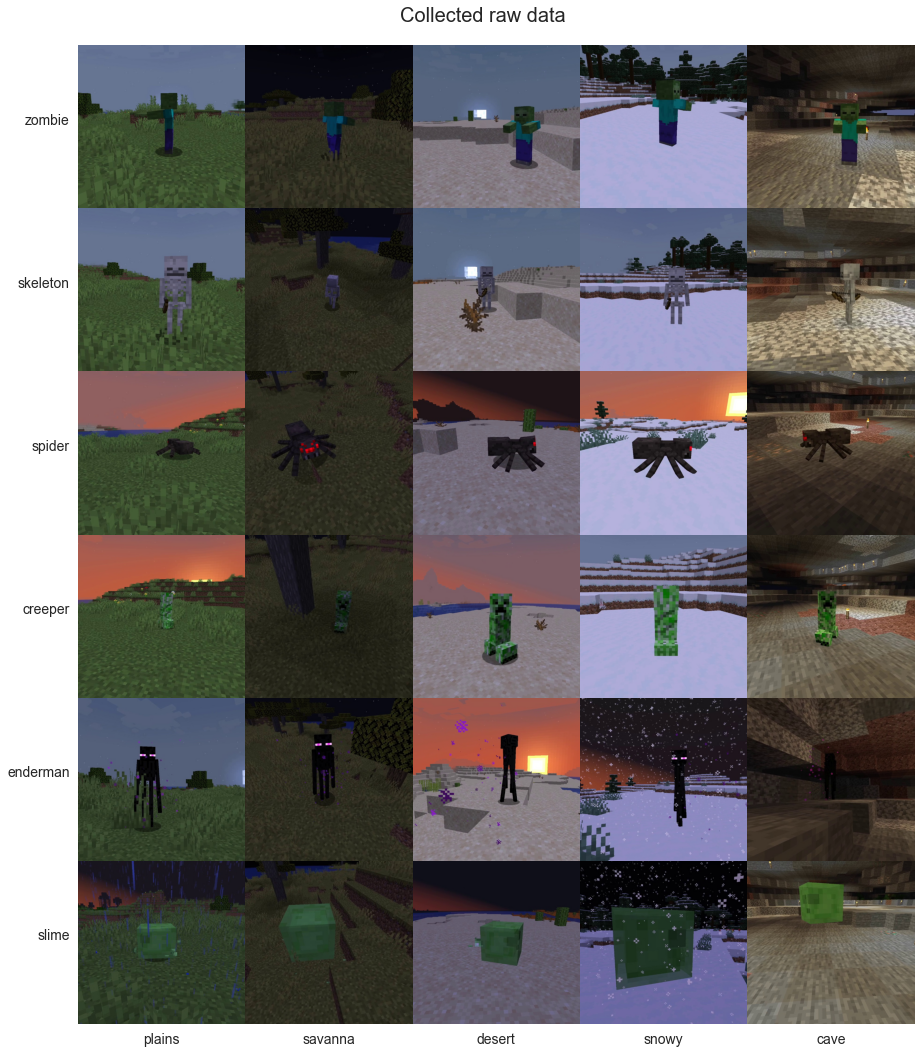

In [9]:
biomes_sample = [
    '00_plains_0_01.jpg',
    '03_savanna_1_25.jpg',
    '04_desert_0_12.jpg',
    '06_snowy_0_01.jpg',
    '08_cave_08.jpg'
]
biomes_sample_names = [i.split('_')[1] for i in biomes_sample]
images_sample = []
for i, mob in enumerate(MOBS):
    mob_dir = DATA_RAW_IMG / f'{i:02}_{mob}'
    for biome in biomes_sample:
        images_sample.append(utils.bgr2rgb(utils.read_image(mob_dir / biome)))

nrows, ncols = 6, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 18))
fig.subplots_adjust(hspace=0.00, wspace=0.00)
fig.suptitle('Collected raw data', y=0.91)
for i, image in enumerate(images_sample):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    utils.reset_axes(ax)

    if col == 0:
        ax.set_ylabel(MOBS[row], rotation=0, labelpad=8, horizontalalignment='right', size=14)
    if row == nrows - 1:
        ax.set_xlabel(biomes_sample_names[col], labelpad=8, size=14)

    ax.imshow(image, aspect='auto')

### Подготовка данных для обучения YOLOv5

In [28]:
def sample_for_labeling(image_path: Path, label_path: Path):
    """Выбирает случайный набор изображений для создания ручной разметки"""
    for i, mob in tqdm(enumerate(MOBS), total=len(MOBS)):
        mob_ = f'{i:02}_{mob}'
        files = list((image_path / mob_).iterdir())
        label_dir = label_path / mob_ / 'images'
        for f in np.sort(RANDOM.choice(files, size=40, replace=False)):
            shutil.copy(f, label_dir)


def clear_label_img_classes(path: Path):
    """Удаляет артефакты работы утилиты labelImg"""
    for i, mob in enumerate(MOBS):
        mob_dir = path / f'{i:02}_{mob}'
        labels_dir = mob_dir / 'labels'

        classes_file = labels_dir / 'classes.txt'
        if classes_file.exists():
            classes_file.unlink()

        for label in labels_dir.iterdir():
            with open(label, 'r') as f:
                data = f.read()
            data = str(i) + data[1:]
            with open(label, 'w') as f:
                f.write(data)


def create_dataset_for_yolo(label_path: Path, dataset_path: Path):
    """Создает датасет из размеченных данных для обучения YOLOv5"""

    def train_augment(img: utils.Image, label: utils.Label) -> list[(utils.Image, utils.Label, str)]:
        orig = utils.transform(utils.a_resize(416, 416), img, label)
        orig_pos_rotated = utils.transform(utils.a_rotate(10), *orig)
        orig_neg_rotated = utils.transform(utils.a_rotate(-10), *orig)
        orig_pos_pos_shear = utils.transform(utils.a_shear(12, 12), *orig)
        orig_neg_pos_shear = utils.transform(utils.a_shear(-12, 12), *orig)
        orig_pos_neg_shear = utils.transform(utils.a_shear(12, -12), *orig)
        orig_neg_neg_shear = utils.transform(utils.a_shear(-12, -12), *orig)

        flipped = utils.transform(utils.a_horizontal_flip(), *orig)
        flipped_pos_rotated = utils.transform(utils.a_rotate(10), *flipped)
        flipped_neg_rotated = utils.transform(utils.a_rotate(-10), *flipped)
        flipped_pos_pos_shear = utils.transform(utils.a_shear(12, 12), *flipped)
        flipped_neg_pos_shear = utils.transform(utils.a_shear(-12, 12), *flipped)
        flipped_pos_neg_shear = utils.transform(utils.a_shear(12, -12), *flipped)
        flipped_neg_neg_shear = utils.transform(utils.a_shear(-12, -12), *flipped)

        return [
            (*orig, ''),
            (*orig_pos_rotated, 'pos_rotated'),
            (*orig_neg_rotated, 'neg_rotated'),
            (*orig_pos_pos_shear, 'pos_pos_shear'),
            (*orig_neg_pos_shear, 'neg_pos_shear'),
            (*orig_pos_neg_shear, 'pos_neg_shear'),
            (*orig_neg_neg_shear, 'neg_neg_shear'),

            (*flipped, 'flip'),
            (*flipped_pos_rotated, 'flip_pos_rotated'),
            (*flipped_neg_rotated, 'flip_neg_rotated'),
            (*flipped_pos_pos_shear, 'pos_pos_shear'),
            (*flipped_neg_pos_shear, 'neg_pos_shear'),
            (*flipped_pos_neg_shear, 'pos_neg_shear'),
            (*flipped_neg_neg_shear, 'neg_neg_shear'),
        ]

    def test_augment(img: utils.Image, label: utils.Label) -> list[(utils.Image, utils.Label, str)]:
        orig = utils.transform(utils.a_resize(416, 416), img, label)
        flipped = utils.transform(utils.a_horizontal_flip(), orig[0], orig[1])
        return [(*orig, ''), (*flipped, 'flip')]

    def save_augment(augment, images: list[Path], labels: list[Path], name: str):
        images_dir = dataset_dir / name / 'images'
        images_dir.mkdir(exist_ok=True, parents=True)
        labels_dir = dataset_dir / name / 'labels'
        labels_dir.mkdir(exist_ok=True, parents=True)
        for img_path, label_path in zip(images, labels):
            img = utils.read_image(img_path)
            label = utils.read_label(label_path)
            augments = augment(img, label)
            for img, label, name in augments:
                utils.write_image(images_dir / f'{"_".join([img_path.stem, name])}.jpg', img)
                utils.write_label(labels_dir / f'{"_".join([label_path.stem, name])}.txt', label)

    multi_data = {'names': [], 'train': [], 'val': [], 'test': []}
    only_train_multi_data = {'names': [], 'train': [], 'val': []}

    for i, mob in tqdm(enumerate(MOBS), total=len(MOBS)):
        mob_ = f'{i:02}_{mob}'

        label_dir = label_path / mob_
        images = sorted((label_dir / 'images').iterdir())
        labels = sorted((label_dir / 'labels').iterdir())
        images_train, images_valid, images_test, labels_train, labels_valid, labels_test = utils.train_valid_test_split(
            images,
            labels,
            train_size=0.8,
            valid_size=0.1
        )

        dataset_dir = dataset_path / mob_

        save_augment(train_augment, images_train, labels_train, 'train')
        save_augment(test_augment, [*images_valid, *images_test], [*labels_valid, *labels_test], 'valid')
        save_augment(test_augment, images_test, labels_test, 'test')

        colab_root = Path('/content')
        train_data_path = str((colab_root / dataset_dir / 'train/images').as_posix())
        valid_data_path = str((colab_root / dataset_dir / 'valid/images').as_posix())
        test_data_path = str((colab_root / dataset_dir / 'test/images').as_posix())

        data = {
            'names': [mob],
            'nc': 1,
            'train': train_data_path,
            'val': valid_data_path,
            'test': test_data_path,
        }
        utils.write_yaml(dataset_dir / 'data.yaml', data)

        multi_data['names'].append(mob)
        multi_data['train'].append(train_data_path)
        multi_data['val'].append(valid_data_path)
        multi_data['test'].append(test_data_path)

        only_train_data_path_list = [train_data_path, valid_data_path, test_data_path]
        only_train_data = {
            'names': [mob],
            'nc': 1,
            'train': only_train_data_path_list,
            'val': only_train_data_path_list,
        }
        utils.write_yaml(dataset_dir / 'only_train_data.yaml', only_train_data)

        only_train_multi_data['names'].append(mob)
        only_train_multi_data['train'].extend(only_train_data_path_list)
        only_train_multi_data['val'].extend(only_train_data_path_list)

    multi_data['nc'] = len(multi_data['names'])
    utils.write_yaml(dataset_path / 'multi_data.yaml', multi_data)

    only_train_multi_data['nc'] = len(only_train_multi_data['names'])
    utils.write_yaml(dataset_path / 'only_train_multi_data.yaml', only_train_multi_data)


In [ ]:
sample_for_labeling(DATA_RAW_IMG, DATA_RAW_LABEL)

In [26]:
clear_label_img_classes(DATA_RAW_LABEL)

In [27]:
create_dataset_for_yolo(DATA_RAW_LABEL, DATA_PROC_YOLO)

  0%|          | 0/6 [00:00<?, ?it/s]

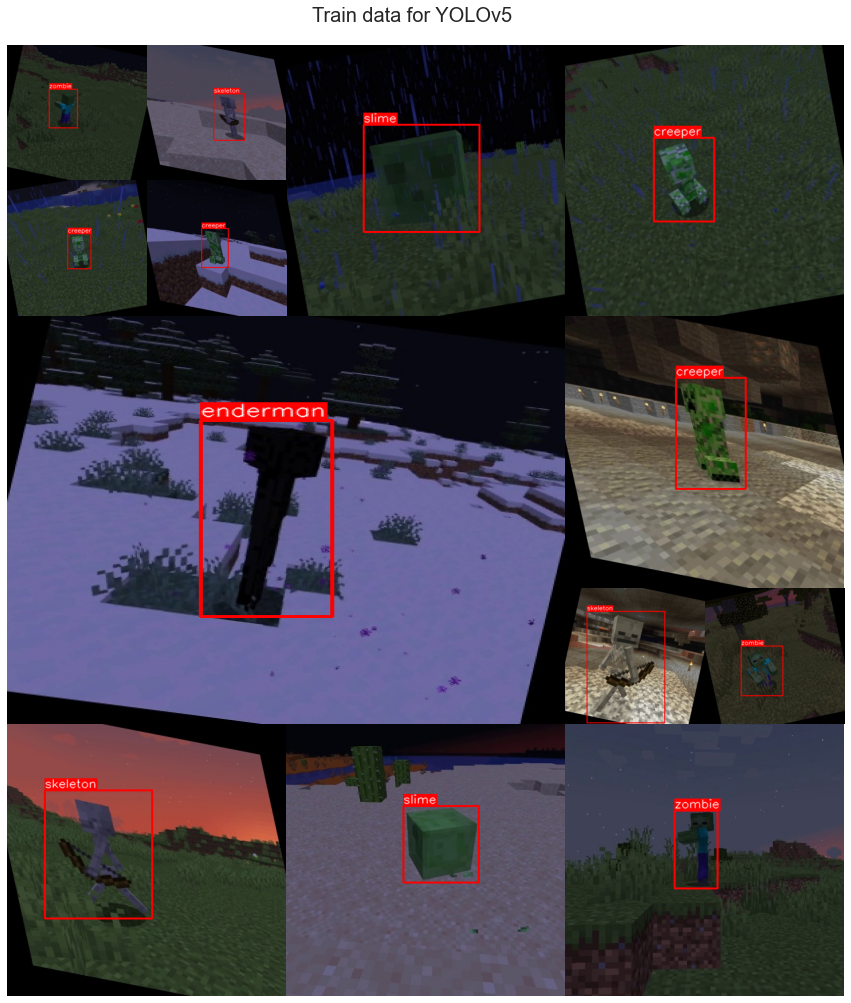

In [24]:
mosaic = """
    ABEEFF
    CDEEFF
    GGGGHH
    GGGGHH
    GGGGKL
    MMNNPP
    MMNNPP
"""

nimages = len(set(mosaic)) - 2
yolo_images_sample = []
yolo_labels_sample = []
yolo_mobs_sample = []
for i, mob in enumerate(MOBS):
    mob_dir = DATA_PROC_YOLO / f'{i:02}_{mob}' / 'train'
    images = sorted((mob_dir / 'images').iterdir())
    labels = sorted((mob_dir / 'labels').iterdir())
    yolo_images_sample.extend(images)
    yolo_labels_sample.extend(labels)
    yolo_mobs_sample.extend([mob] * len(images))

yolo_sample = RANDOM.choice(
    list(zip(yolo_images_sample, yolo_labels_sample, yolo_mobs_sample)),
    size=nimages,
    replace=False
)

fig: Figure = plt.figure(figsize=(15, 15 / (6 / 7)))
fig.subplots_adjust(hspace=0.00, wspace=0.00)
fig.suptitle('Train data for YOLOv5', y=0.91)
axes = list(fig.subplot_mosaic(mosaic).values())

for i, (img, label, mob) in enumerate(yolo_sample):
    img = utils.bgr2rgb(utils.read_image(img))
    label = utils.read_label(label)
    ax = axes[i]
    utils.reset_axes(ax)
    ax.imshow(utils.visualize_bbox(img, label[1], mob), aspect='auto')